In [70]:
import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [54]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [55]:
df = data.load_asset('SOLUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2022-01-01']
df.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2022-01-01,170.01,179.20,169.93,179.06,634599.39,1.105852e+08,179793,328250.16,5.720231e+07,21.0,Extreme Fear
2022-01-02,179.06,179.53,174.31,176.35,620087.38,1.095093e+08,176256,313106.42,5.529423e+07,29.0,Fear
2022-01-03,176.34,176.49,166.59,170.15,1031316.43,1.772404e+08,250131,537423.71,9.233145e+07,29.0,Fear
2022-01-04,170.14,173.93,166.47,167.72,1041332.63,1.765382e+08,264666,507127.47,8.602990e+07,23.0,Extreme Fear
2022-01-05,167.74,171.32,144.92,154.52,1659848.17,2.669799e+08,460130,775826.33,1.250144e+08,24.0,Extreme Fear


In [56]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    df['MA_7'] = df['Close'].rolling(window=7).mean()

    df['MA_14'] = df['Close'].rolling(window=14).mean()


    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df


In [57]:
df = add_technical_features(df)
df.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14
Open time,,,,,,,,,,,,,,,,
2022-01-15,147.64,865014.75,Extreme Fear,0.010007,0.045833,36.653378,0.0,-31.42,5.59,3.31,-2.28,0.488251,0.001623,-1.990527,144.048571,150.423571
2022-01-16,147.98,964270.14,Extreme Fear,0.002300,0.046030,37.144767,0.0,-28.37,5.87,4.35,-1.52,0.493713,0.001653,-1.205626,145.071429,148.397143
2022-01-17,139.80,1297654.14,Extreme Fear,-0.056864,0.047179,30.928612,0.0,-30.35,11.27,0.31,-10.96,0.477513,0.001535,-0.734132,145.634286,146.229286
2022-01-18,141.22,1254337.17,Extreme Fear,0.010106,0.047617,33.023994,0.0,-26.50,8.38,2.96,-5.42,0.488271,0.001526,-0.168769,145.780000,144.336429
2022-01-19,135.25,1175171.39,Extreme Fear,-0.043194,0.044261,29.035855,0.0,-19.27,9.93,1.38,-8.55,0.493523,0.001646,-0.092659,143.457143,142.960000


In [58]:
df = data.train_test_split(df)

In [59]:
df.to_csv("tmp_df_data.csv")

`train_lstm` creates the X and y lists, splits them to train and val. It also creates the model and fits it.

In [ ]:
# Hyperparameters (from Optuna)
UNITS_L0 = 160
DROPOUT_L0 = 0.0
LEARNING_RATE = 0.000728
BATCH_SIZE = 32
MAX_EPOCHS = 50

def train_lstm(df, sequence_length=30, test_size=0.2, target='MA_7'):
    # Prepare data
    features = [
        'Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume', 
        'slope', 'MA_7', 'MA_14'
    ]
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    target_idx = list(df_all.columns).index(target)
    # Move the target column to the last position
    columns = list(df_all.columns)
    columns.append(columns.pop(target_idx))
    df_all = df_all[columns]
    target_idx = len(columns) - 1

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all)
    display(df_all)
    display(data_scaled)

    # Build sequences
    X, y = zip(*[
        (data_scaled[i-sequence_length:i], data_scaled[i, target_idx])
        for i in range(sequence_length, len(data_scaled))
    ])
    X, y = np.array(X), np.array(y)

    # Train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Build and compile model
    model = Sequential([
        Input(shape=(sequence_length, X.shape[2])),
        LSTM(UNITS_L0, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='mean_squared_error')

    # Train model
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1)

    return model, scaler, history, (X_val, y_val)



In [103]:
# Train Model for Predicting MV7
model_mv7, scaler_mv7, history_mv7, (X_val_mv7, y_val_mv7) = train_lstm(df, target='MA_7')


,Close,Volume,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_14,F_G_Extreme Fear,F_G_Extreme Greed,F_G_Fear,F_G_Greed,F_G_Neutral,MA_7
Open time,,,,,,,,,,,,,,,,,,,,
2022-01-15,147.64,865014.750,0.010007,0.045833,36.653378,0.000000,-31.42,5.59,3.31,-2.28,0.488251,0.001623,-1.990527,150.423571,True,False,False,False,False,144.048571
2022-01-16,147.98,964270.140,0.002300,0.046030,37.144767,0.000000,-28.37,5.87,4.35,-1.52,0.493713,0.001653,-1.205626,148.397143,True,False,False,False,False,145.071429
2022-01-17,139.80,1297654.140,-0.056864,0.047179,30.928612,0.000000,-30.35,11.27,0.31,-10.96,0.477513,0.001535,-0.734132,146.229286,True,False,False,False,False,145.634286
2022-01-18,141.22,1254337.170,0.010106,0.047617,33.023994,0.000000,-26.50,8.38,2.96,-5.42,0.488271,0.001526,-0.168769,144.336429,True,False,False,False,False,145.780000
2022-01-19,135.25,1175171.390,-0.043194,0.044261,29.035855,0.000000,-19.27,9.93,1.38,-8.55,0.493523,0.001646,-0.092659,142.960000,True,False,False,False,False,143.457143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,138.43,2466162.683,0.007905,0.046648,48.936611,21.642746,15.06,4.59,2.87,-1.72,0.502310,0.003882,0.761341,133.003571,False,False,True,False,False,135.750000
2025-03-28,129.49,3892191.365,-0.066761,0.045868,43.586818,20.785795,-4.05,11.36,0.61,-10.75,0.460476,0.003057,0.678637,132.714286,False,False,True,False,False,135.894286
2025-03-29,124.58,2610065.515,-0.038656,0.046475,40.939683,20.504670,-11.28,7.86,1.04,-6.82,0.499399,0.003576,0.549934,131.908571,False,False,True,False,False,135.332857


array([[0.54690287, 0.00637074, 0.67297814, ..., 0.        , 0.        ,
        0.55129126],
       [0.54825031, 0.00926291, 0.6637008 , ..., 0.        , 0.        ,
        0.5555052 ],
       [0.51583244, 0.01897728, 0.59247462, ..., 0.        , 0.        ,
        0.55782405],
       ...,
       [0.4555146 , 0.05721922, 0.61439548, ..., 0.        , 0.        ,
        0.51538443],
       [0.45646574, 0.03197667, 0.66324858, ..., 0.        , 0.        ,
        0.51066434],
       [0.45535608, 0.08987096, 0.65822802, ..., 0.        , 0.        ,
        0.50097109]])

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0668 - val_loss: 0.0060
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7223e-04 - val_loss: 0.0019
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2021e-04 - val_loss: 0.0016
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0102e-04 - val_loss: 0.0011
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8338e-04 - val_loss: 8.9183e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4608e-04 - val_loss: 0.0010
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.2680e-04 - val_loss: 7.4669e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1913e-04 - val_loss: 9.5426e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.8271e-05 - val_loss: 5.2447e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0818e-04 - val_loss: 4.5778e-04
Epoch 1

In [107]:
# Train Model for Predicting Close Price
model_close, scaler_close, history_close, (X_val_close, y_val_close) = train_lstm(df, target='Close')


,Volume,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope,MA_7,MA_14,F_G_Extreme Fear,F_G_Extreme Greed,F_G_Fear,F_G_Greed,F_G_Neutral,Close
Open time,,,,,,,,,,,,,,,,,,,,
2022-01-15,865014.750,0.010007,0.045833,36.653378,0.000000,-31.42,5.59,3.31,-2.28,0.488251,0.001623,-1.990527,144.048571,150.423571,True,False,False,False,False,147.64
2022-01-16,964270.140,0.002300,0.046030,37.144767,0.000000,-28.37,5.87,4.35,-1.52,0.493713,0.001653,-1.205626,145.071429,148.397143,True,False,False,False,False,147.98
2022-01-17,1297654.140,-0.056864,0.047179,30.928612,0.000000,-30.35,11.27,0.31,-10.96,0.477513,0.001535,-0.734132,145.634286,146.229286,True,False,False,False,False,139.80
2022-01-18,1254337.170,0.010106,0.047617,33.023994,0.000000,-26.50,8.38,2.96,-5.42,0.488271,0.001526,-0.168769,145.780000,144.336429,True,False,False,False,False,141.22
2022-01-19,1175171.390,-0.043194,0.044261,29.035855,0.000000,-19.27,9.93,1.38,-8.55,0.493523,0.001646,-0.092659,143.457143,142.960000,True,False,False,False,False,135.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,2466162.683,0.007905,0.046648,48.936611,21.642746,15.06,4.59,2.87,-1.72,0.502310,0.003882,0.761341,135.750000,133.003571,False,False,True,False,False,138.43
2025-03-28,3892191.365,-0.066761,0.045868,43.586818,20.785795,-4.05,11.36,0.61,-10.75,0.460476,0.003057,0.678637,135.894286,132.714286,False,False,True,False,False,129.49
2025-03-29,2610065.515,-0.038656,0.046475,40.939683,20.504670,-11.28,7.86,1.04,-6.82,0.499399,0.003576,0.549934,135.332857,131.908571,False,False,True,False,False,124.58


array([[0.00637074, 0.67297814, 0.16441566, ..., 0.        , 0.        ,
        0.54690287],
       [0.00926291, 0.6637008 , 0.16563524, ..., 0.        , 0.        ,
        0.54825031],
       [0.01897728, 0.59247462, 0.17277535, ..., 0.        , 0.        ,
        0.51583244],
       ...,
       [0.05721922, 0.61439548, 0.16840211, ..., 0.        , 0.        ,
        0.4555146 ],
       [0.03197667, 0.66324858, 0.14149882, ..., 0.        , 0.        ,
        0.45646574],
       [0.08987096, 0.65822802, 0.14002066, ..., 0.        , 0.        ,
        0.45535608]])

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0426 - val_loss: 0.0081
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0047
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8715e-04 - val_loss: 0.0054
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.6943e-04 - val_loss: 0.0052
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.1016e-04 - val_loss: 0.0031
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1384e-04 - val_loss: 0.0031
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2577e-04 - val_loss: 0.0036
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1556e-04 - val_loss: 0.0035
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2990e-04 - val_loss: 0.0034
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0594e-04 - val_loss: 0.0031


In [108]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict MV7
y_pred_mv7 = model_mv7.predict(X_val_mv7).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy_mv7 = np.zeros((len(y_pred_mv7), X_val_mv7.shape[2]))
dummy_mv7[:, -1] = y_pred_mv7

# Inverse transform using the entire dummy array
y_pred_mv7_inv = scaler_mv7.inverse_transform(dummy_mv7)[:, -1]

# Inverse transform for the actual values
dummy_y_val_mv7 = np.zeros((len(y_val_mv7), X_val_mv7.shape[2]))
dummy_y_val_mv7[:, -1] = y_val_mv7
y_val_mv7_inv = scaler_mv7.inverse_transform(dummy_y_val_mv7)[:, -1]

# Predict Close
y_pred_close = model_close.predict(X_val_close).flatten()

# Create a placeholder array with zeros, except for the last column (target)
dummy_close = np.zeros((len(y_pred_close), X_val_close.shape[2]))
dummy_close[:, -1] = y_pred_close

# Inverse transform using the entire dummy array
y_pred_close_inv = scaler_close.inverse_transform(dummy_close)[:, -1]

# Inverse transform for the actual values
dummy_y_val_close = np.zeros((len(y_val_close), X_val_close.shape[2]))
dummy_y_val_close[:, -1] = y_val_close
y_val_close_inv = scaler_close.inverse_transform(dummy_y_val_close)[:, -1]

# Benchmark: Naive model (predicting tomorrow's close as today's close)
naive_close = df['Close'].iloc[-len(y_pred_close_inv)-1:-1].values

# Print shapes for verification
print("Shapes:")
print(f"y_pred_mv7_inv: {y_pred_mv7_inv.shape}, y_val_mv7_inv: {y_val_mv7_inv.shape}")
print(f"y_pred_close_inv: {y_pred_close_inv.shape}, y_val_close_inv: {y_val_close_inv.shape}")
print(f"Naive benchmark shape: {naive_close.shape}")

# MSE Calculation
mse_mv7 = mean_squared_error(y_val_mv7_inv, y_pred_mv7_inv)
mse_close = mean_squared_error(y_val_close_inv, y_pred_close_inv)
mse_naive = mean_squared_error(y_val_close_inv, naive_close)

# Print MSE
print(f"MSE (Predicted MV7 - Tomorrow's Close): {mse_mv7:.4f}")
print(f"MSE (Predicted Close - Tomorrow's Close): {mse_close:.4f}")
print(f"MSE (Naive Model - Today's Close as Tomorrow's Close): {mse_naive:.4f}")



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Shapes:
y_pred_mv7_inv: (229,), y_val_mv7_inv: (229,)
y_pred_close_inv: (229,), y_val_close_inv: (229,)
Naive benchmark shape: (229,)
MSE (Predicted MV7 - Tomorrow's Close): 24.0585
MSE (Predicted Close - Tomorrow's Close): 195.6181
MSE (Naive Model - Today's Close as Tomorrow's Close): 70.2398


In [115]:
mse_mv7 = mean_squared_error(y_val_close_inv, y_pred_mv7_inv)
print(f"MSE (Predicted MV7 - Tomorrow's Close): {mse_mv7:.4f}")


MSE (Predicted MV7 - Tomorrow's Close): 169.6132


In [109]:
df["MA_7_pred"] = np.nan
df.loc[df.index[-len(y_pred_mv7_inv):], "MA_7_pred"] = y_pred_mv7_inv

<Axes: title={'center': 'Close Price and MA_7'}, xlabel='Open time'>

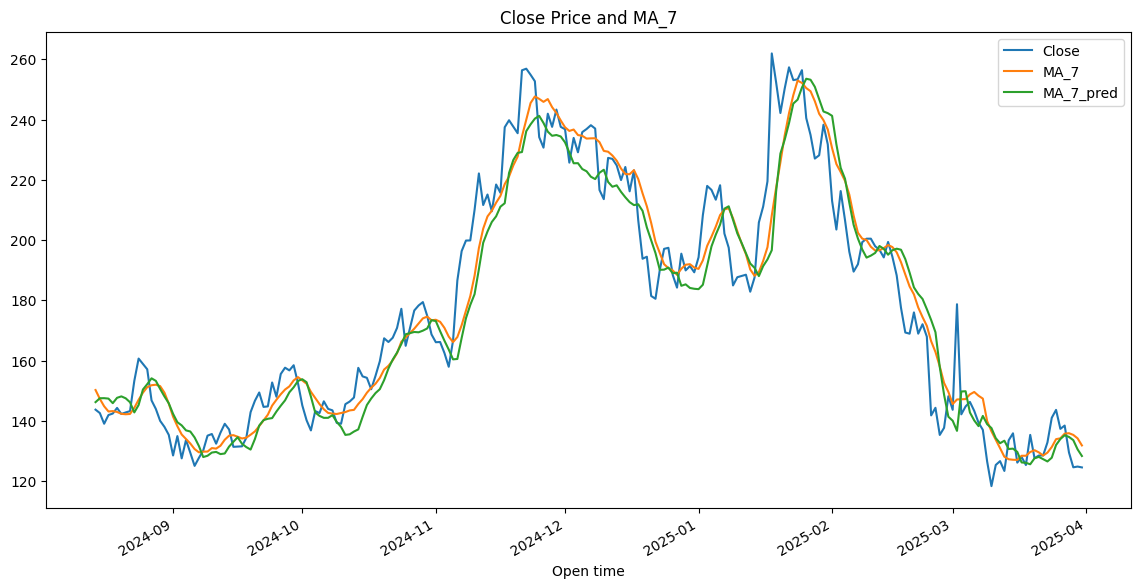

In [111]:
df[["Close", "MA_7", "MA_7_pred"]].iloc[-len(y_pred_mv7_inv):].plot(figsize=(14, 7), title="Close Price and MA_7")

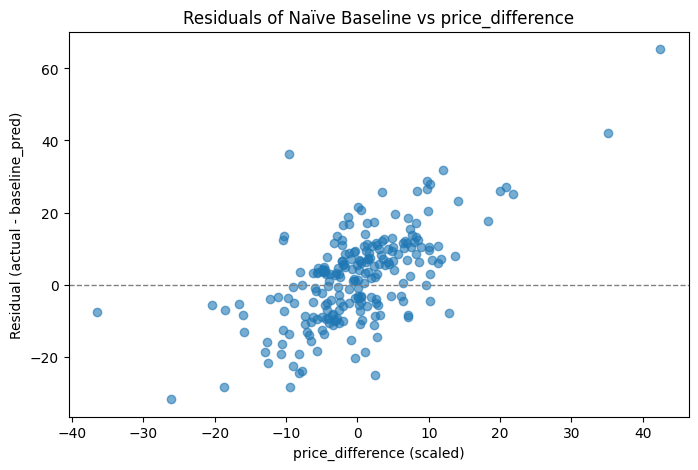

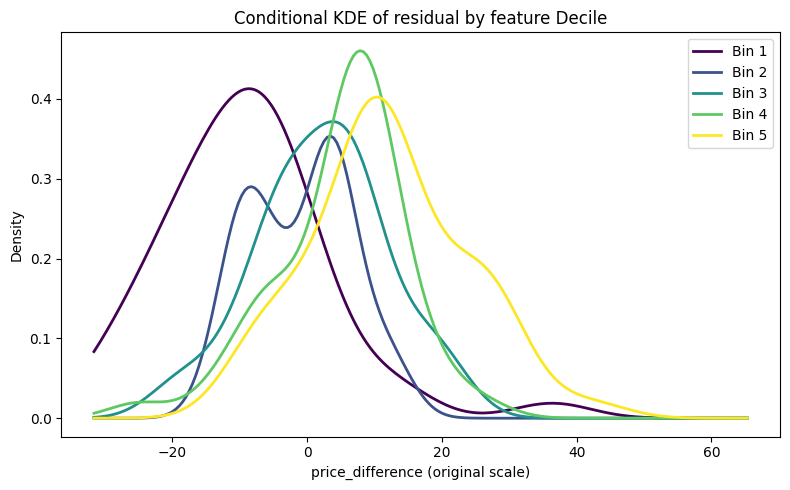

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# 3) Compute residuals relative to baseline
# residuals_baseline = preds - baseline_preds
residuals_baseline = y_val_close_inv - y_pred_mv7_inv

# 4) Extract the same feature (e.g. 'RSI') for X-axis
feature_to_plot = 'price_difference'  # or 'RSI', etc.

X_feat = y_val_close_inv - pd.Series(y_val_close_inv).shift(1)


# 5) Plot residuals of the benchmark vs. feature
plt.figure(figsize=(8,5))
plt.scatter(X_feat, residuals_baseline, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel(f'{feature_to_plot} (scaled)')
plt.ylabel('Residual (actual - baseline_pred)')
plt.title(f'Residuals of Naïve Baseline vs {feature_to_plot}')
plt.show()


# fig, (ax_scatter, ax_hist) = plt.subplots(2, 1, figsize=(8, 10))

# # Scatter: baseline residuals vs feature
# ax_scatter.scatter(X_feat, residuals_baseline, alpha=0.6)
# ax_scatter.axhline(0, color='gray', linestyle='--', linewidth=1)
# ax_scatter.set_xlabel(f'{feature_to_plot} (scaled)')
# ax_scatter.set_ylabel('Residual (actual - baseline_pred)')
# ax_scatter.set_title(f'Residuals of Naïve Baseline vs {feature_to_plot}')

data = pd.DataFrame({'X': residuals_baseline, 'Y': X_feat})
data.dropna(inplace=True)


# bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
# cond_vals = []
# for i in range(len(bins)-1):
#     mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
#     x_bin = data.loc[mask, 'X']
#     if len(x_bin) > 1:
#         x_std = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
#         cond_vals.append(x_std)
# cond_X = pd.concat(cond_vals, ignore_index=True)

# ax_hist.hist(cond_X, bins=30, density=True, alpha=0.7)
# ax_hist.set_xlabel(f'{feature_to_plot} (standardized within Y-bins)')
# ax_hist.set_ylabel('Density')
# ax_hist.set_title('Distribution of Detrended Conditional Feature')

# plt.tight_layout()
# plt.show()

bins = np.quantile(data['Y'], np.linspace(0, 1, 11))
bins = np.quantile(data['Y'], np.linspace(0, 1, 6))

# Prepare a grid for plotting
x_min, x_max = data['X'].min(), data['X'].max()
x_grid = np.linspace(x_min, x_max, 200)

# Choose a colormap and number of bins
cmap = plt.get_cmap("viridis")
n_bins = len(bins) - 1
z_grid = np.linspace(-3, 3, 200)   # covers ±3σ

plt.figure(figsize=(8,5))
for i in range(n_bins):
    mask = (data['Y'] >= bins[i]) & (data['Y'] < bins[i+1])
    x_bin = data.loc[mask, 'X']
    if len(x_bin) > 1:
        # Standardize within bin
        mean_i = x_bin.mean()
        std_i  = x_bin.std(ddof=0)
        x_std = (x_bin - mean_i) / std_i
        
        # Fit KDE on standardized data
        kde = stats.gaussian_kde(x_std)
        
        # Evaluate KDE on grid (standardize grid same as x_bin)
        x_std_grid = (x_grid - mean_i) / std_i
        y_kde = kde(x_std_grid)

        
        z = (x_bin - x_bin.mean()) / x_bin.std(ddof=0)
        # fit KDE
        kde = stats.gaussian_kde(z)
        # evaluate on the z-grid
        y_kde = kde(z_grid)
        
        # Compute color and line width as gradient
        frac = i / (n_bins - 1)
        color = cmap(frac)
        # linewidth = 0.5 + 2.5 * frac
        linewidth = 2

        if len(x_bin) < 30:
            alpha = 0.5
            linewidth = 0.5
        else:
            alpha = 1
        
        plt.plot(
            x_grid, kde(x_std_grid),
            color=color,
            linewidth=linewidth,
            label=f'Bin {i+1}',
            alpha=alpha
        )
        plt.xlabel(f'{feature_to_plot} (original scale)')
        plt.ylabel('Density')

        # plt.plot(
        #     z_grid, kde(z_grid),
        #     color=cmap(frac),
        #     linewidth=0.5 + 2.5*frac,
        #     label=f'Bin {i+1}'
        # )
        # plt.xlabel(f'z-score of {feature_to_plot}')
        # plt.ylabel('Density')

plt.title('Conditional KDE of residual by feature Decile')
plt.legend()
# Optional: only show legend if desired
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()
